# Only environment x has a diffusion process

$$dh(t)=n(t)-T(n(t))dt$$
$$dx(t)=(a-\eta x(t))dt+\sigma dB(t)$$
$$dx(t)=\eta(\frac{a}{\eta}-x(t))dt+\sigma dB(t)$$

草稿保存在打草.ipynb里面，注意不要把它删掉。

Translate1_17.m中，habit从0到100，由于效用函数导致图像在起始端点附近的值为NaN。

KFE_TwoDiffusion_2_12.m中，h是扩散过程，所以XYZ有不同，h从0.01开始到100。

## 计算


这个太慢了，按照第三部分的代码来运行，快。

In [58]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

gamma=3;
epsilon=-0.2;

rho=0.9;
C=10;
k=0.6;
p=0.5;

a=1;
eta=0.6;
xmean=a/eta;
sigma=0.8;
sd=sigma**2/2/eta
xmin=xmean-2*sd
xmax=xmean+2*sd

I=1000;
hmin=0;
hmax=100;
h=np.linspace(hmin,hmax,I);   #列向量  
                              #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
h=h.reshape(I,1);
#print(h);
dh=(hmax-hmin)/(I-1);

J=7;
x=np.linspace(xmin,xmax,J);    # 行向量
x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
dx=(xmax-xmin)/(J-1);
dx2=dx**2;

hh=np.dot(h,np.ones((1,J)));
xx=np.dot(np.ones((I,1)),x);

mu=a-x*eta;      
s2=0.5*sigma**2;

Vhf = np.zeros((I,J));
Vhb = np.zeros((I,J));
Vxf = np.zeros((I,J));
Vxb = np.zeros((I,J));
Vxx = np.zeros((I,J));
n = np.zeros((I,J));

chi =  - np.minimum(mu,0)/dx + s2/dx2;              
yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
zeta = np.maximum(mu,0)/dx + s2/dx2;

maxit=100;
crit=10**(-6);
Delta=1000;

updiag=np.zeros((I,1));
for j in range(0,J,1):
    gg=np.tile(zeta[0][j],(I,1));
    updiag=np.vstack([updiag,gg]);

centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
for j in range(1,J-1,1):
    gg=np.tile(yy[0][j],(I,1));
    centdiag=np.vstack([centdiag,gg]);
gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
centdiag=np.vstack([centdiag,gg])

lowdiag=np.tile(chi[0][1],(I,1));
for j in range(2,J,1):
    gg=np.tile(chi[0][j],(I,1));
    lowdiag=np.vstack([lowdiag,gg]);

centdiag=np.transpose(centdiag);
Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
lowdiag=np.transpose(lowdiag);
Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
updiag=np.transpose(updiag);
Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
v=v0;

maxit=30;
distm=np.zeros(maxit);
for m in range(0,maxit,1):   
    V=copy.deepcopy(v);
    Vhf=np.zeros((I,J));
    Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;
    
    Vhb=np.zeros((I,J));
    Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhb[0,:]=(V[1,:]-V[0,:])/dh;

    I_concave=(Vhb>Vhf)+0;

    nf=((1-k)/C*Vhf)**epsilon;
    hf=(1-k)*nf-p*hh;

    nb=((1-k)/C*Vhb)**epsilon;
    hb=(1-k)*nb-p*hh;
    
    n0=p/(1-k)*hh;
    Vh0=C/(1-k)*n0**(1/epsilon);

    If=(hf>0)+0;
    Ib=(hb<0)+0;

    I0=(1-If-Ib);

    Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

    n=((1-k)/C*Vh_Upwind)**epsilon;
    u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);
    
    where_are_nan = np.isnan(hb)
    hb[where_are_nan] = 0
    where_are_nan = np.isnan(hf)
    hf[where_are_nan] = 0
    
    X=-np.minimum(hb,0)/dh;
    Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
    Z=np.maximum(hf,0)/dh;

    updiag=0;
    for j in range(0,J,1):
        pp=Z[0:I-1,j];
        pp=pp.reshape(I-1,1)
        gg=np.vstack([pp,0]);
        updiag=np.vstack([updiag,gg]);
        
    Y=np.transpose(Y);
    centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

    lowdiag=X[1:I,0];
    lowdiag=lowdiag.reshape(I-1,1);
    for j in range(1,J,1):
        pp=X[1:I,j];
        pp=pp.reshape(I-1,1);
        gg=np.vstack([0,pp]);
        lowdiag=np.vstack([lowdiag,gg]);

    centdiag=np.transpose(centdiag);
    AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
    
    lowdiag=np.vstack([lowdiag,0]);
    lowdiag=np.transpose(lowdiag);
    AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();
    
    updiag=np.vstack([updiag,0]);
    updiag=np.transpose(updiag);
    AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();
    
    AA=AA_centdiag+AA_lowdiag+AA_updiag;

    A=AA+Bswitch;

    if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
        print("Improper Transition Matrix")
        break;

    B=(1/Delta+rho)*identity(I*J).toarray()-A;
    invB=np.linalg.inv(B);

    u=np.transpose(u);
    u_stacked=copy.deepcopy(u.reshape(I*J,1));
    V=np.transpose(V);
    V_stacked=copy.deepcopy(V.reshape(I*J,1));
    

    b=u_stacked+V_stacked/Delta;

    invBcopy=copy.deepcopy(invB);
    bcopy=np.tile(b,(1,I*J))

    for j in range(0,I*J,1):
        for i in range(0,I*J,1):
            if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
                if invBcopy[j,i]==0:   
                    bcopy[i,j]=0;
    

    V_stacked2=np.zeros((I*J,1))
    for j in range(0,I*J,1):
        V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])

    V=copy.deepcopy(V_stacked2.reshape(J,I));
    V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

    Vchange=V-v;

    v=copy.deepcopy(V);
    
    Vchangecopy=copy.deepcopy(Vchange)
    where_are_nan = np.isnan(Vchangecopy)
    where_are_inf = np.isinf(Vchangecopy)
    Vchangecopy[where_are_nan] = 0
    Vchangecopy[where_are_inf] = 0
    
    distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
    print(distm[m]);
    print(m);
    if distm[m]<crit:
        print("Value Function Converged, Iteration =");
        print(m);
        print(distm[m]);
        break;

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in power
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in power
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in multiply
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: divide by zero encountered in power


28.25192115715134
0


E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in greater
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in less


KeyboardInterrupt: 

## 画图

### habit的导数

<IPython.core.display.Javascript object>


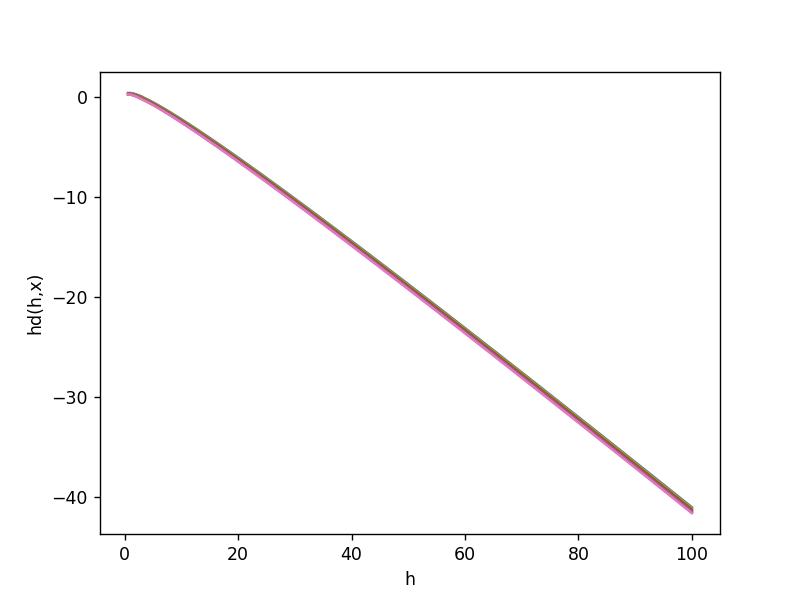

In [2]:
ncopy=copy.deepcopy(n)
hhcopy=copy.deepcopy(hh)
hd=(1-k)*ncopy-p*hhcopy

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,hd[:,j])
# plt.title("Sales for the first 6 months") #图名
plt.xlabel("h")#x轴标签
plt.ylabel("hd(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
 
plt.savefig('figure2.1.pdf')#保存图片，一定要在show之前保存图片，否则保存的图片就为空白
plt.show()


### n

<IPython.core.display.Javascript object>


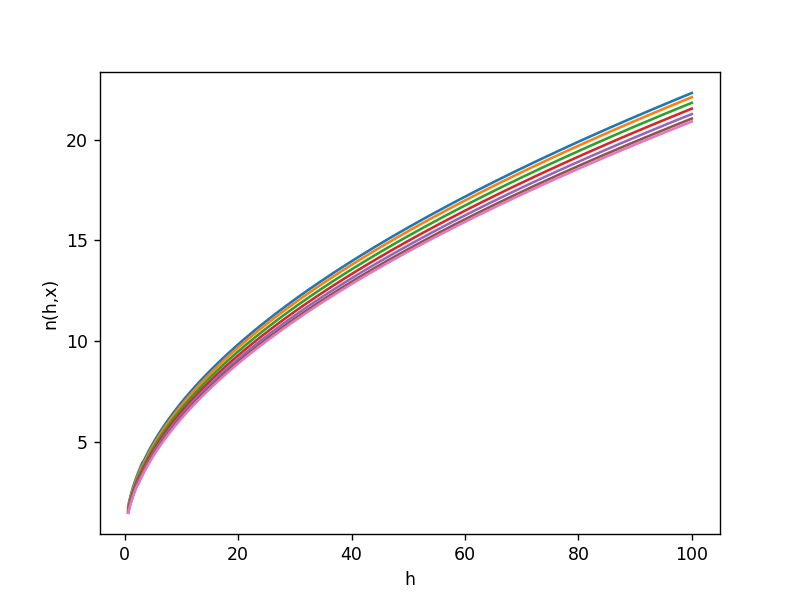

In [3]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,n[:,j])
plt.xlabel("h")#x轴标签
plt.ylabel("n(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
plt.savefig('figure2.2.pdf')
plt.show()



<IPython.core.display.Javascript object>


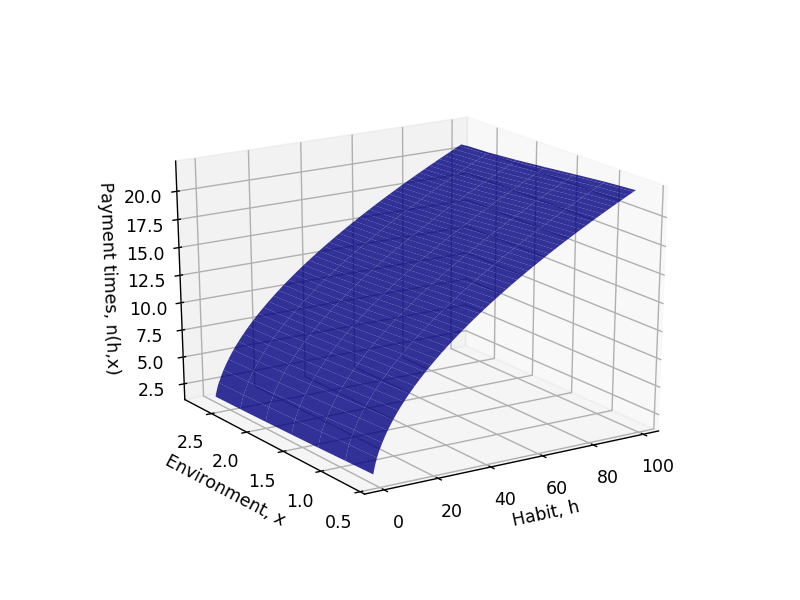

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Z contains NaN values. This may result in rendering artifacts.
E:\Anaconda1\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [4]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

# ax.patch.set_facecolor("white") 



hcopy=copy.deepcopy(h)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=990;
hcut=hcopy[0:icut,:]
ncut=ncopy[0:icut,:]

hcut=hcut.reshape((1,icut))
ncut=np.transpose(ncut)

# max_ncut=a.any(max(ncut))
# min_ncut=min(ncut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,ncut,cmap='jet',alpha=0.8)
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('Payment times, n(h,x)')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
plt.savefig('figure2.3.pdf')
plt.show()

### ValueFunction

<IPython.core.display.Javascript object>


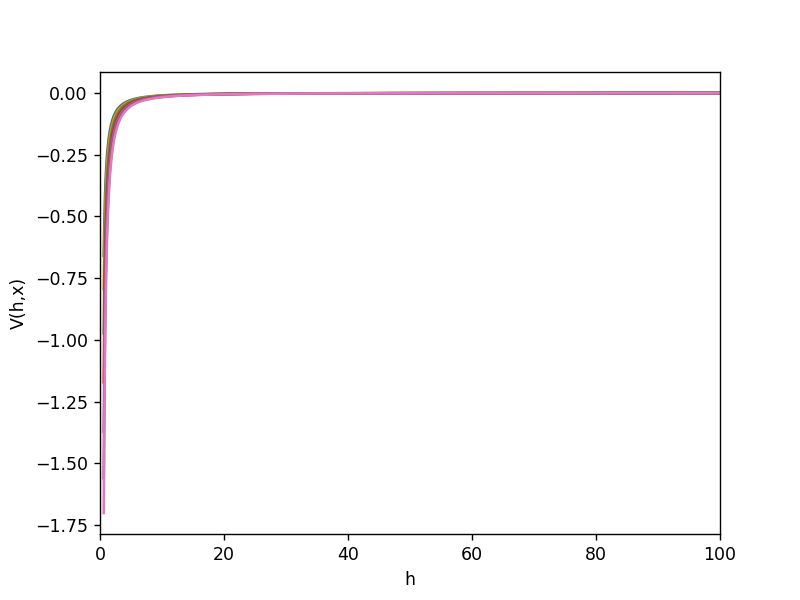

In [5]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,V[:,j])
plt.xlabel("h")#x轴标签
plt.ylabel("V(h,x)")#y轴标签
plt.xlim(0,hmax)
# %plt.ylim(-1.75,0.5)
plt.tick_params(axis='both')#x,y轴都有刻度
# plt.savefig('figure2.png')
plt.savefig('figure2.4.pdf')
plt.show()

### Distribution

In [6]:
AT=np.transpose(A)
b5=np.zeros((I*J,1))
i_fix=5
b5[i_fix-1,0]=0.1
row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
AT[i_fix-1,:]=row
invAT=np.linalg.inv(AT);
gg=np.dot(invAT,b5);

g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

gg=gg/g_sum
# g=np.transpose(gg).reshape(I,J)
ggcopy=copy.deepcopy(gg)
# ggcopy=np.transpose(ggcopy)
g=ggcopy.reshape(J,I)
g=np.transpose(g)

<IPython.core.display.Javascript object>


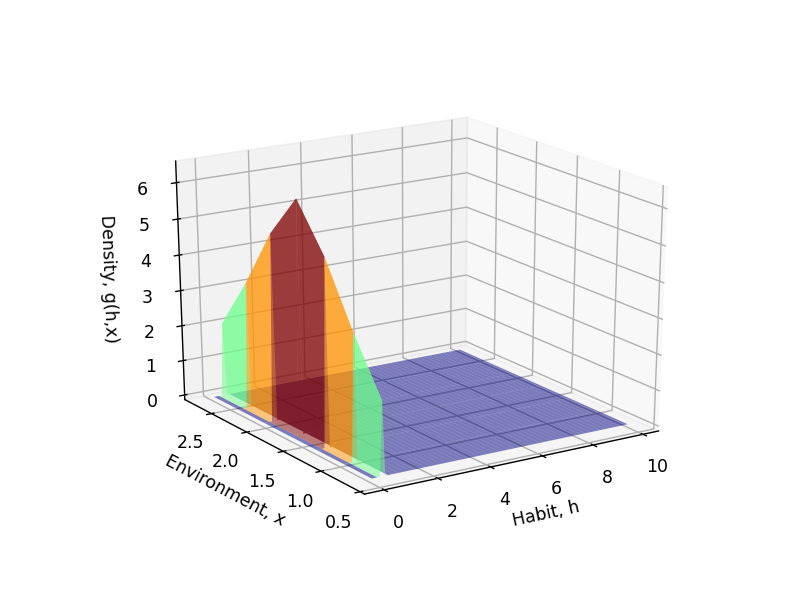

In [7]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

gcopy=copy.deepcopy(g)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=100;
hcut=hcopy[0:icut,:]
gcut=gcopy[0:icut,:]

hcut=hcut.reshape((1,icut))
gcut=np.transpose(gcut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

fig = plt.figure()
ax = plt.gca(projection='3d')
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('Density, g(h,x)')
# ax.set_xlim(hmin,np.maximum(hcut))
# ax.set_ylim()
# ax.set_zlim()
# ax.add_collection3d(Poly3DCollection(poly3d, facecolors='w', linewidths=1, alpha=0.5))


# ax.add_collection3d(Poly3DCollection(ax,alpha=0.5))
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,gcut,cmap='jet',alpha=0.5)
plt.savefig('figure2.5.pdf')
plt.show()

# Both habit and environment have diffusion processes

这一部分没有用了。


但是它的参数是有用的。


注意，此部分的X，Y，Z与上一部分不同。

$$dh(t)=(n(t)-T(n(t)))dt+\sigma_1h(t)dB_t$$
$$dx(t)=(a-\eta x(t))dt+\sigma_2 dB(t)$$

## 计算

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

gamma=0.9;
epsilon=-0.3;

rho=0.9;
C=50;
k=0.9;
p=0.5;

a=0.8;
eta=0.6;
xmean=a/eta;
sigma2=0.8;
sd=sigma2**2/2/eta
xmin=xmean-2*sd
xmax=xmean+2*sd

I=1000;
hmin=0.01;
hmax=100;
h=np.linspace(hmin,hmax,I);  
                            
h=h.reshape(I,1);
dh=(hmax-hmin)/(I-1);
dh2=dh**2;
sigma1=0.00001;

J=7;
x=np.linspace(xmin,xmax,J); 
x=x.reshape(1,J);    
dx=(xmax-xmin)/(J-1);
dx2=dx**2;

hh=np.dot(h,np.ones((1,J)));
xx=np.dot(np.ones((I,1)),x);

mu2=a-x*eta;      
s2=0.5*sigma2**2;

Vhf = np.zeros((I,J));
Vhb = np.zeros((I,J));
Vxf = np.zeros((I,J));
Vxb = np.zeros((I,J));
Vxx = np.zeros((I,J));
n = np.zeros((I,J));

chi =  - np.minimum(mu2,0)/dx + s2/dx2;              
yy =  np.minimum(mu2,0)/dx - np.maximum(mu2,0)/dx - s2*2/dx2;
zeta = np.maximum(mu2,0)/dx + s2/dx2;

maxit=100;
crit=10**(-6);
Delta=1000;

updiag=np.zeros((I,1));
for j in range(0,J,1):
    gg=np.tile(zeta[0][j],(I,1));
    updiag=np.vstack([updiag,gg]);

centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
for j in range(1,J-1,1):
    gg=np.tile(yy[0][j],(I,1));
    centdiag=np.vstack([centdiag,gg]);
gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
centdiag=np.vstack([centdiag,gg])

lowdiag=np.tile(chi[0][1],(I,1));
for j in range(2,J,1):
    gg=np.tile(chi[0][j],(I,1));
    lowdiag=np.vstack([lowdiag,gg]);

centdiag=np.transpose(centdiag);
Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
lowdiag=np.transpose(lowdiag);
Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
updiag=np.transpose(updiag);
Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
v=v0;

maxit=20;
distm=np.zeros(maxit);
for m in range(0,maxit,1):   
    V=copy.deepcopy(v);
    Vhf=np.zeros((I,J));
    Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;
    
    Vhb=np.zeros((I,J));
    Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhb[0,:]=(V[1,:]-V[0,:])/dh;

    I_concave=(Vhb>Vhf)+0;

    nf=((1-k)/C*Vhf)**epsilon;
    hf=(1-k)*nf-p*hh;

    nb=((1-k)/C*Vhb)**epsilon;
    hb=(1-k)*nb-p*hh;
    
    n0=p/(1-k)*hh;
    Vh0=C/(1-k)*n0**(1/epsilon);

    If=(hf>0)+0;
    Ib=(hb<0)+0;

    I0=(1-If-Ib);

    Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

    n=((1-k)/C*Vh_Upwind)**epsilon;
    u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);
  
    where_are_nan = np.isnan(hb)
    hb[where_are_nan] = 0
    where_are_nan = np.isnan(hf)
    hf[where_are_nan] = 0
    
    X=-np.minimum(hb,0)/dh+(sigma1**2*hh*hh)/(2*dh2);
    Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh-(sigma1**2*hh*hh)/(dh2);
    Z=np.maximum(hf,0)/dh+(sigma1**2*hh*hh)/(2*dh2);

    updiag=0;
    for j in range(0,J,1):
        pp=Z[0:I-1,j];
        pp=pp.reshape(I-1,1)
        gg=np.vstack([pp,0]);
        updiag=np.vstack([updiag,gg]);
        
    Y=np.transpose(Y);
    centdiag=Y.reshape(I*J,1);  

    lowdiag=X[1:I,0];
    lowdiag=lowdiag.reshape(I-1,1);
    for j in range(1,J,1):
        pp=X[1:I,j];
        pp=pp.reshape(I-1,1);
        gg=np.vstack([0,pp]);
        lowdiag=np.vstack([lowdiag,gg]);

    centdiag=np.transpose(centdiag);
    AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
    
    lowdiag=np.vstack([lowdiag,0]);
    lowdiag=np.transpose(lowdiag);
    AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();
    
    updiag=np.vstack([updiag,0]);
    updiag=np.transpose(updiag);
    AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();
    
    AA=AA_centdiag+AA_lowdiag+AA_updiag;

    A=AA+Bswitch;

    if np.max(abs(np.sum(A,axis=1)))>10**(-3):   #这个最大值不太一样    
        print("Improper Transition Matrix")
        break;

    B=(1/Delta+rho)*identity(I*J).toarray()-A;
    invB=np.linalg.inv(B);

    u=np.transpose(u);
    u_stacked=copy.deepcopy(u.reshape(I*J,1));
    V=np.transpose(V);
    V_stacked=copy.deepcopy(V.reshape(I*J,1));
    

    b=u_stacked+V_stacked/Delta;

    invBcopy=copy.deepcopy(invB);
    bcopy=np.tile(b,(1,I*J))

    for j in range(0,I*J,1):
        for i in range(0,I*J,1):
            if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
                if invBcopy[j,i]==0:
                    bcopy[i,j]=0;
    V_stacked2=np.zeros((I*J,1))
    for j in range(0,I*J,1):
        V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])

    V=copy.deepcopy(V_stacked2.reshape(J,I));
    V=np.transpose(V);  
    
    Vchange=V-v;

    v=copy.deepcopy(V);

    Vchangecopy=copy.deepcopy(Vchange)
    where_are_nan = np.isnan(Vchangecopy)
    where_are_inf = np.isinf(Vchangecopy)
    Vchangecopy[where_are_nan] = 0
    Vchangecopy[where_are_inf] = 0
    
    distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
    print(distm[m]);
    print(m);
    if distm[m]<crit:
        print("Value Function Converged, Iteration =");
        print(m);
        print(distm[m]);
        break;

11.709891095556543
0
0.49486995586840976
1
0.012652013937916706
2
1.6358193880350314e-05
3
4.3171368702132895e-09
4
Value Function Converged, Iteration =
4
4.3171368702132895e-09


## 画图
### habit的导数

In [ ]:
# ncopy=copy.deepcopy(n)
hhcopy=copy.deepcopy(hh)
hd=(1-k)*ncopy-p*hhcopy

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,hd[:,j])
# plt.title("Sales for the first 6 months") #图名
plt.xlabel("h")#x轴标签
plt.ylabel("hd(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
 
plt.savefig('figure3.1.pdf')#保存图片，一定要在show之前保存图片，否则保存的图片就为空白
plt.show()

### n

<IPython.core.display.Javascript object>


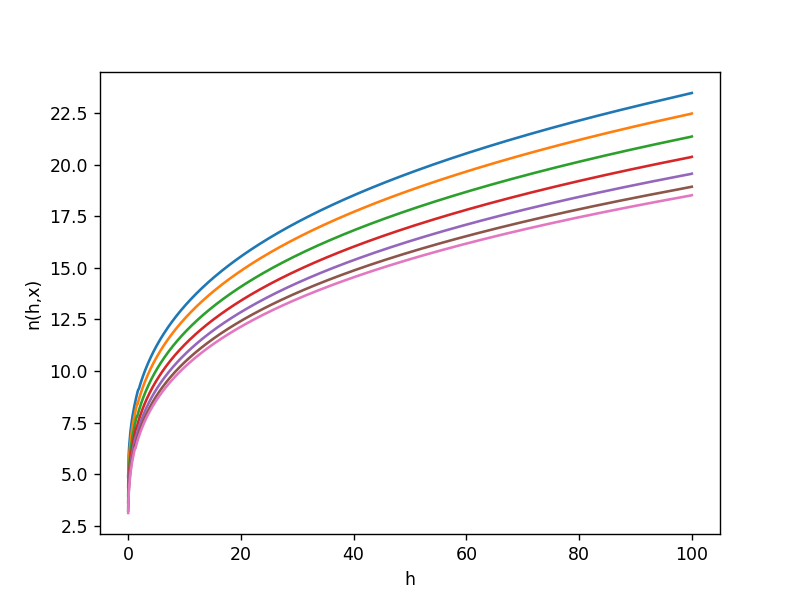

In [10]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,n[:,j])
plt.xlabel("h")#x轴标签
plt.ylabel("n(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
plt.savefig('figure3.2.pdf')
plt.show()


<IPython.core.display.Javascript object>


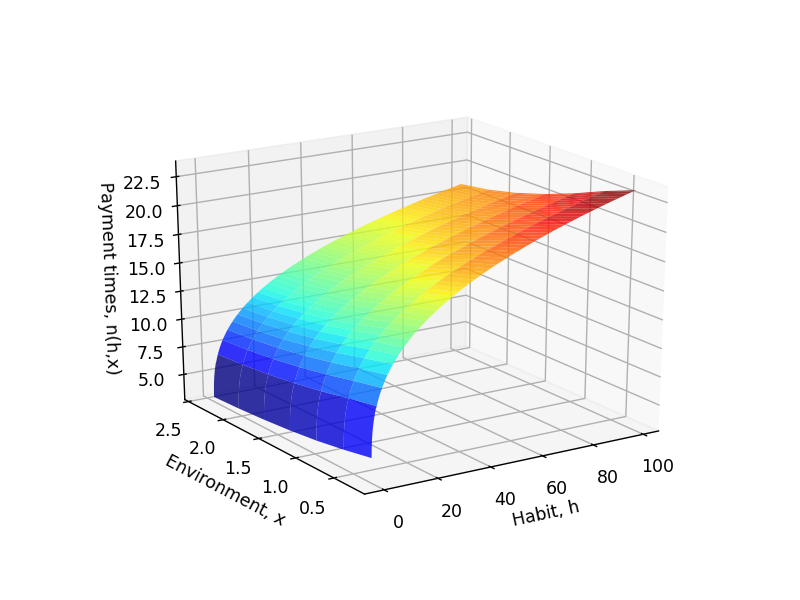

In [11]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

# ax.patch.set_facecolor("white") 



hcopy=copy.deepcopy(h)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=990;
hcut=hcopy[0:icut,:]
ncut=ncopy[0:icut,:]

hcut=hcut.reshape((1,icut))
ncut=np.transpose(ncut)

# max_ncut=a.any(max(ncut))
# min_ncut=min(ncut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,ncut,cmap='jet',alpha=0.8)
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('Payment times, n(h,x)')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
plt.savefig('figure3.3.pdf')
plt.show()

### ValueFunction

<IPython.core.display.Javascript object>


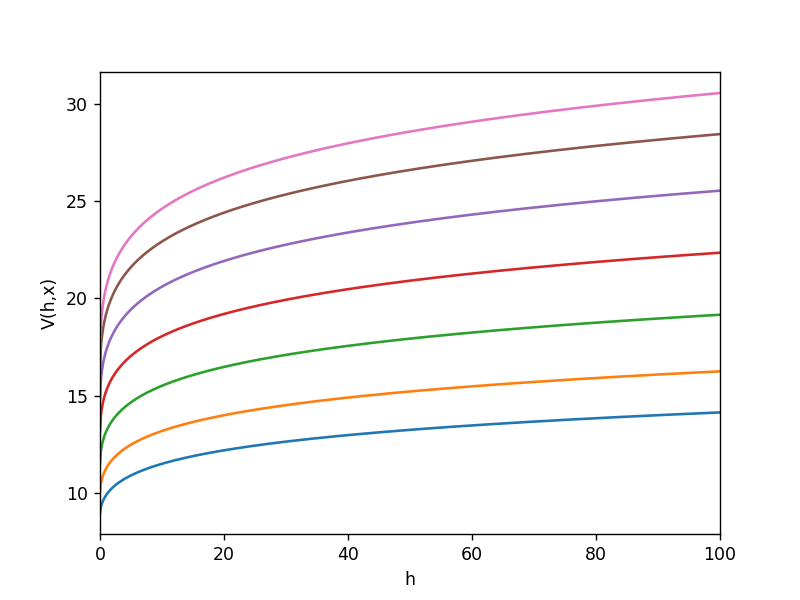

In [12]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,V[:,j])
plt.xlabel("h")#x轴标签
plt.ylabel("V(h,x)")#y轴标签
plt.xlim(0,hmax)
# %plt.ylim(-1.75,0.5)
plt.tick_params(axis='both')#x,y轴都有刻度
# plt.savefig('figure2.png')
plt.savefig('figure3.4.pdf')
plt.show()

### Distribution

In [13]:
AT=np.transpose(A)
b5=np.zeros((I*J,1))
i_fix=5
b5[i_fix-1,0]=0.1
row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
AT[i_fix-1,:]=row
invAT=np.linalg.inv(AT);
gg=np.dot(invAT,b5);

g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

gg=gg/g_sum
# g=np.transpose(gg).reshape(I,J)
ggcopy=copy.deepcopy(gg)
# ggcopy=np.transpose(ggcopy)
g=ggcopy.reshape(J,I)
g=np.transpose(g)

<IPython.core.display.Javascript object>


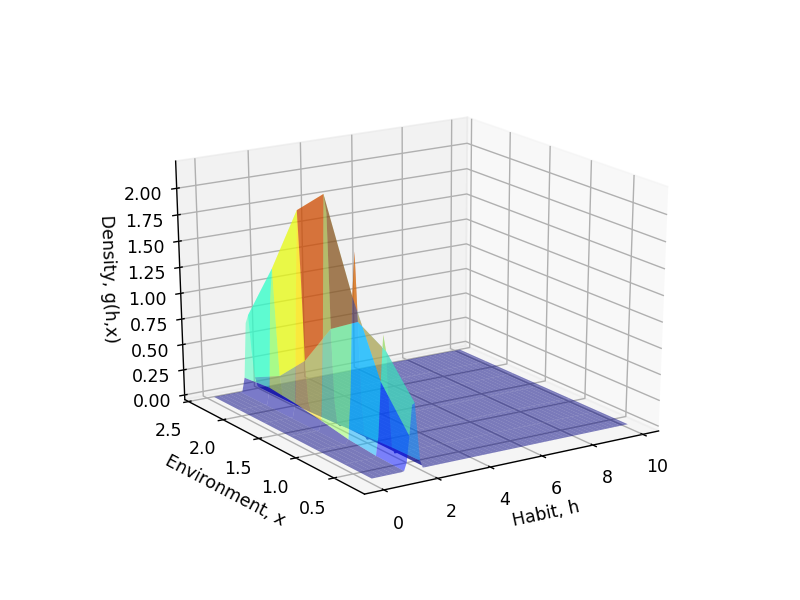

In [14]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

gcopy=copy.deepcopy(g)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=100;
hcut=hcopy[0:icut,:]
gcut=gcopy[0:icut,:]

hcut=hcut.reshape((1,icut))
gcut=np.transpose(gcut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

fig = plt.figure()
ax = plt.gca(projection='3d')
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('Density, g(h,x)')
# ax.set_xlim(hmin,np.maximum(hcut))
# ax.set_ylim()
# ax.set_zlim()
# ax.add_collection3d(Poly3DCollection(poly3d, facecolors='w', linewidths=1, alpha=0.5))


# ax.add_collection3d(Poly3DCollection(ax,alpha=0.5))
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,gcut,cmap='jet',alpha=0.5)
plt.savefig('figure3.5.pdf')
plt.show()

# 采取快捷方式将矩阵中的nan值替换为0

有问题，输出结果为nan。没弄好。3.6


ValueFunction有问题，可能是因为计算中对inf和nan的替换较为粗略所导致的 3.7 好了  3.7


现在下面是用h从0.001开始，只有x扩散得到的结果

## 计算


这个快，运行一遍只需要三十秒

In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy


gamma=3;#0.9
epsilon=-0.2;#-0.3

rho=0.9;
C=10;
k=0.9;
p=0.5;

a=1;
eta=0.6;
xmean=a/eta;
sigma=0.8;
sd=sigma**2/2/eta
xmin=xmean-2*sd
xmax=xmean+2*sd

I=1000;
hmin=0.0001;
hmax=100;
h=np.linspace(hmin,hmax,I);   #列向量  
                              #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
h=h.reshape(I,1);
#print(h);
dh=(hmax-hmin)/(I-1);

J=7;
x=np.linspace(xmin,xmax,J);    # 行向量
x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
dx=(xmax-xmin)/(J-1);
dx2=dx**2;

hh=np.dot(h,np.ones((1,J)));
xx=np.dot(np.ones((I,1)),x);

mu=a-x*eta;      
s2=0.5*sigma**2;

Vhf = np.zeros((I,J));
Vhb = np.zeros((I,J));
Vxf = np.zeros((I,J));
Vxb = np.zeros((I,J));
Vxx = np.zeros((I,J));
n = np.zeros((I,J));

chi =  - np.minimum(mu,0)/dx + s2/dx2;              
yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
zeta = np.maximum(mu,0)/dx + s2/dx2;

maxit=100;
crit=10**(-6);
Delta=1000;

updiag=np.zeros((I,1));
for j in range(0,J,1):
    gg=np.tile(zeta[0][j],(I,1));
    updiag=np.vstack([updiag,gg]);

centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
for j in range(1,J-1,1):
    gg=np.tile(yy[0][j],(I,1));
    centdiag=np.vstack([centdiag,gg]);
gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
centdiag=np.vstack([centdiag,gg])

lowdiag=np.tile(chi[0][1],(I,1));
for j in range(2,J,1):
    gg=np.tile(chi[0][j],(I,1));
    lowdiag=np.vstack([lowdiag,gg]);

centdiag=np.transpose(centdiag);
Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
lowdiag=np.transpose(lowdiag);
Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
updiag=np.transpose(updiag);
Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
v=v0;

maxit=30;
distm=np.zeros(maxit);
for m in range(0,maxit,1):   
    V=copy.deepcopy(v);
    Vhf=np.zeros((I,J));
    Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;
    
    Vhb=np.zeros((I,J));
    Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhb[0,:]=(V[1,:]-V[0,:])/dh;

    I_concave=(Vhb>Vhf)+0;

    nf=((1-k)/C*Vhf)**epsilon;
    hf=(1-k)*nf-p*hh;

    nb=((1-k)/C*Vhb)**epsilon;
    hb=(1-k)*nb-p*hh;
    
#     n0=p/(1-k)*hh;
#     Vh0=C/(1-k)*n0**(1/epsilon);

    If=(hf>0)+0;
    Ib=(hb<0)+0;

    I0=(1-If-Ib);

    Vh_Upwind=Vhf*If+Vhb*Ib#+Vh0*I0;

    n=((1-k)/C*Vh_Upwind)**epsilon;
    u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);
    
    aaa=np.nan_to_num(hf,nan=0)
    hf=aaa
    aaa=np.nan_to_num(hb,nan=0)
    hb=aaa
#     where_are_nan = np.isnan(hb)
#     hb[where_are_nan] = 0
#     where_are_nan = np.isnan(hf)
#     hf[where_are_nan] = 0
    
    X=-np.minimum(hb,0)/dh;
    Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
    Z=np.maximum(hf,0)/dh;

    updiag=0;
    for j in range(0,J,1):
        pp=Z[0:I-1,j];
        pp=pp.reshape(I-1,1)
        gg=np.vstack([pp,0]);
        updiag=np.vstack([updiag,gg]);
        
    Y=np.transpose(Y);
    centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

    lowdiag=X[1:I,0];
    lowdiag=lowdiag.reshape(I-1,1);
    for j in range(1,J,1):
        pp=X[1:I,j];
        pp=pp.reshape(I-1,1);
        gg=np.vstack([0,pp]);
        lowdiag=np.vstack([lowdiag,gg]);

    centdiag=np.transpose(centdiag);
    AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
    
    lowdiag=np.vstack([lowdiag,0]);
    lowdiag=np.transpose(lowdiag);
    AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();
    
    updiag=np.vstack([updiag,0]);
    updiag=np.transpose(updiag);
    AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();
    
    AA=AA_centdiag+AA_lowdiag+AA_updiag;

    A=AA+Bswitch;

    if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
        print("Improper Transition Matrix")
        break;

    B=(1/Delta+rho)*identity(I*J).toarray()-A;
    invB=np.linalg.inv(B);

    u=np.transpose(u);
    u_stacked=copy.deepcopy(u.reshape(I*J,1));
    V=np.transpose(V);
    V_stacked=copy.deepcopy(V.reshape(I*J,1));
    

    b=u_stacked+V_stacked/Delta;

    invBcopy=copy.deepcopy(invB);
#     bcopy=np.tile(b,(1,I*J))

#     for j in range(0,I*J,1):
#         for i in range(0,I*J,1):
#             if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
#                 if invBcopy[j,i]==0:   #注意这句话的意思.想办法用别的方式换掉这个for循环
#                     bcopy[i,j]=0;
#     aaa=np.nan_to_num(b,nan=0,posinf=0,neginf=0)
#     b=aaa
    
#     V_stacked2=np.dot(invBcopy,b)
#     V_stacked2=np.zeros((I*J,1))
#     for j in range(0,I*J,1):
#         V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])
    
    bcopy=np.tile(np.transpose(b),(I*J,1))
    index=np.where(np.isnan(bcopy))
    for i in range(0,len(index[0]),1):
        if invBcopy[index[0][i],index[1][i]]==0:
            bcopy[index[0][i],index[1][i]]=0
    
    index=np.where(np.isinf(bcopy))
    for i in range(0,len(index[0]),1):
        if invBcopy[index[0][i],index[1][i]]==0:
            bcopy[index[0][i],index[1][i]]=0
    
    V_stacked2=invBcopy*bcopy
    V_stacked2=V_stacked2.sum(axis=1)
    V_stacked2=V_stacked2.reshape(I*J,1)
    
    
    V=copy.deepcopy(V_stacked2.reshape(J,I));
    V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

    Vchange=V-v;

    v=copy.deepcopy(V);
    
    Vchangecopy=copy.deepcopy(Vchange)
    aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
    Vchangecopy=aaa
#     where_are_nan = np.isnan(Vchangecopy)
#     where_are_inf = np.isinf(Vchangecopy)
#     Vchangecopy[where_are_nan] = 0
#     Vchangecopy[where_are_inf] = 0
    
    distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
    print(distm[m]);
    print(m);
    if distm[m]<crit:
        print("Value Function Converged, Iteration =");
        print(m);
        print(distm[m]);
        break;

37021716.445029244
0
8248897.659241779
1
19049.523333059158
2
17.87526738923043
3
0.01771936466684565
4
1.8062943127006292e-05
5
2.9802322387695312e-08
6
Value Function Converged, Iteration =
6
2.9802322387695312e-08
Wall time: 55.4 s


## 画图

<IPython.core.display.Javascript object>


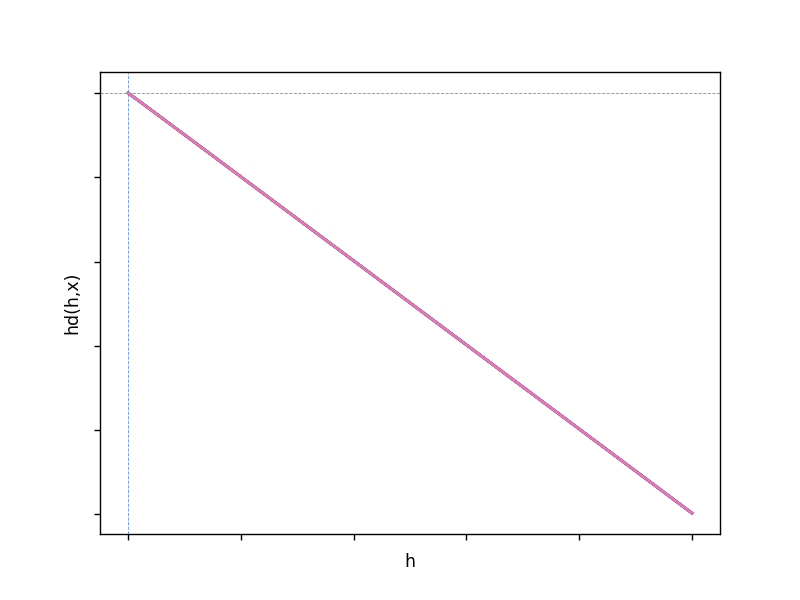

[]

In [3]:
ncopy=copy.deepcopy(n)
hhcopy=copy.deepcopy(hh)
hd=(1-k)*ncopy-p*hhcopy

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.axhline(y=0,linewidth=0.5,color='cornflowerblue', linestyle='dashed')
plt.axvline(x=0,linewidth=0.5,color='cornflowerblue', linestyle='dashed')
for j in range(0,J,1):
    plt.plot(h,hd[:,j])
# plt.title("Sales for the first 6 months") #图名
plt.xlabel("h")#x轴标签
plt.ylabel("h'(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.savefig('figure3.10.1.pdf')#保存图片，一定要在show之前保存图片，否则保存的图片就为空白
# plt.show()

<IPython.core.display.Javascript object>


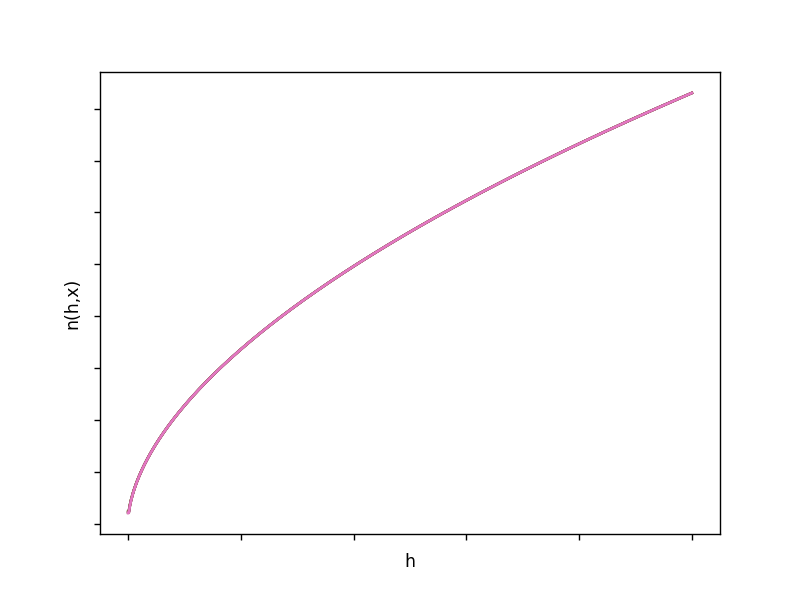

In [4]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,n[:,j])
plt.xlabel("h")#x轴标签
plt.ylabel("n(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
# plt.savefig('figure3.10.2.pdf')

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.show()


<IPython.core.display.Javascript object>


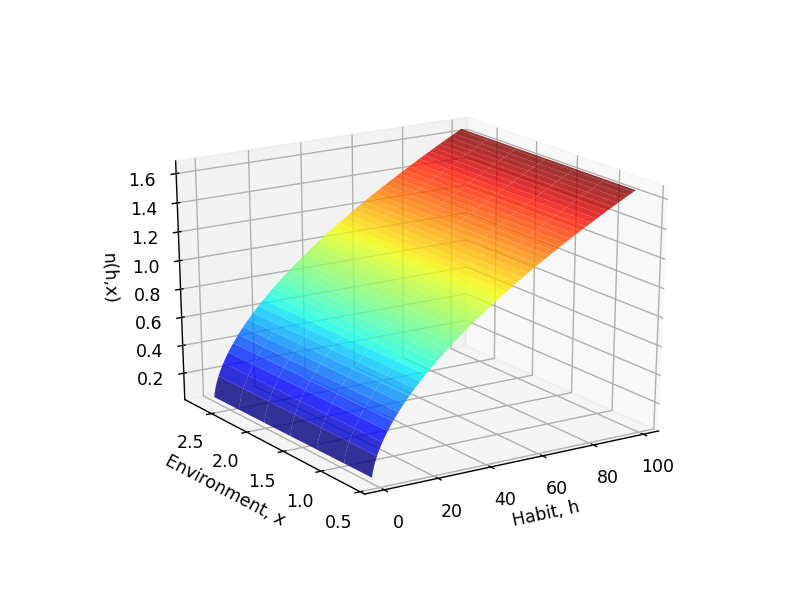

In [5]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

# ax.patch.set_facecolor("white") 



hcopy=copy.deepcopy(h)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=990;
hcut=hcopy[0:icut,:]
ncut=ncopy[0:icut,:]

hcut=hcut.reshape((1,icut))
ncut=np.transpose(ncut)

# max_ncut=a.any(max(ncut))
# min_ncut=min(ncut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,ncut,cmap='jet',alpha=0.8)
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('n(h,x)')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
plt.savefig('figure3.10.3.pdf')
plt.show()

<IPython.core.display.Javascript object>


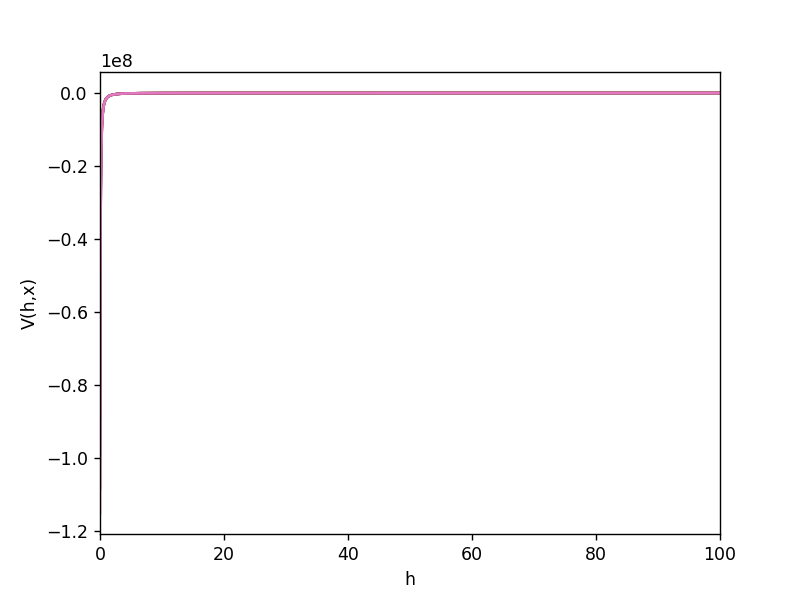

In [6]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,V[:,j])
plt.xlabel("h")#x轴标签
plt.ylabel("V(h,x)")#y轴标签
plt.xlim(0,hmax)
# %plt.ylim(-1.75,0.5)
plt.tick_params(axis='both')#x,y轴都有刻度
# plt.savefig('figure2.png')
# plt.savefig('figure2.10.4.pdf')
# plt.show()

In [2]:
AT=np.transpose(A)
b5=np.zeros((I*J,1))
i_fix=5
b5[i_fix-1,0]=0.1
row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
AT[i_fix-1,:]=row
invAT=np.linalg.inv(AT);
gg=np.dot(invAT,b5);

g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

gg=gg/g_sum
# g=np.transpose(gg).reshape(I,J)
ggcopy=copy.deepcopy(gg)
# ggcopy=np.transpose(ggcopy)
g=ggcopy.reshape(J,I)
g=np.transpose(g)

<IPython.core.display.Javascript object>


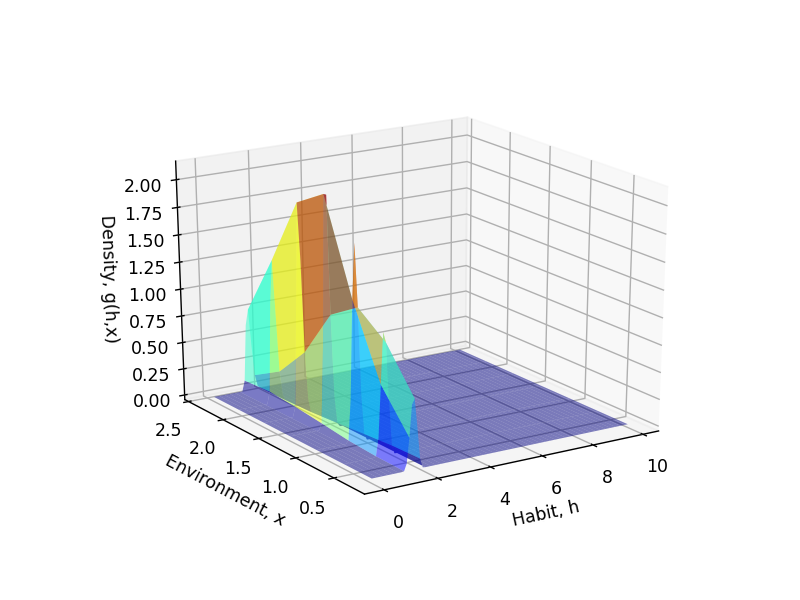

In [17]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

gcopy=copy.deepcopy(g)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=100;
hcut=hcopy[0:icut,:]
gcut=gcopy[0:icut,:]

hcut=hcut.reshape((1,icut))
gcut=np.transpose(gcut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

fig = plt.figure()
ax = plt.gca(projection='3d')
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('Density, g(h,x)')
# ax.set_xlim(hmin,np.maximum(hcut))
# ax.set_ylim()
# ax.set_zlim()
# ax.add_collection3d(Poly3DCollection(poly3d, facecolors='w', linewidths=1, alpha=0.5))


# ax.add_collection3d(Poly3DCollection(ax,alpha=0.5))
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,gcut,cmap='jet',alpha=0.5)
plt.savefig('figure3.10.5.pdf')
plt.show()

### 把一些结果输出到excel里 

In [13]:
writer = pd.ExcelWriter('A.xlsx',engine='openpyxl')
I0IN_df = pd.DataFrame(g)
book = load_workbook('A.xlsx')
writer.book = book
I0IN_df.to_excel(writer, sheet_name='g')
writer.save()

把循环中的那个给想办法解决了

In [13]:
%%time
rrr=np.array([np.nan,0,1,2,3,np.nan]);
hhh=np.array([np.nan,0,1,7,3,np.nan]);
# print('Yuan shi de rrr',rrr)
aaa=np.nan_to_num(rrr,nan=0)
# print('aaa',aaa)
rrr=aaa;
# print('gaibianzhihou d rrr',rrr)

aaa=np.nan_to_num(hhh,nan=0)
hhh=aaa
print(rrr,hhh)
# print(np.nan_to_num(rrr,nan=0))

[0. 0. 1. 2. 3. 0.] [0. 0. 1. 7. 3. 0.]
Wall time: 997 µs


In [34]:
rrr=np.array([[np.nan,0,1,2,3,np.nan],[np.inf,10,11,12,13,np.nan]]);
where_are_nan = np.isnan(rrr)
print(where_are_nan)
rrr[where_are_nan] = 0
print(rrr)

where_are_nan_trans=np.transpose(where_are_nan)
print(where_are_nan_trans)
# where_are_nan = np.isnan(hf)
# hf[where_are_nan] = 0

[[ True False False False False  True]
 [False False False False False  True]]
[[ 0.  0.  1.  2.  3.  0.]
 [inf 10. 11. 12. 13.  0.]]
[[ True False]
 [False False]
 [False False]
 [False False]
 [False False]
 [ True  True]]


In [ ]:
    invBcopy=copy.deepcopy(invB);
    bcopy=np.tile(b,(1,I*J))

#     for j in range(0,I*J,1):
#         for i in range(0,I*J,1):
#             if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
#                 if invBcopy[j,i]==0:   #注意这句话的意思.想办法用别的方式换掉这个for循环
#                     bcopy[i,j]=0;
    aaa=np.nan_to_num(b,nan=0,posinf=0,neginf=0)
    b=aaa
    
    V_stacked2=np.dot(invBcopy,b)
#     V_stacked2=np.zeros((I*J,1))
#     for j in range(0,I*J,1):
#         V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])

    V=copy.deepcopy(V_stacked2.reshape(J,I));
    V=np.transpose(V);

In [34]:
import numpy as np

invb=np.array([[10,20,30,0,50,0,70,80,0,100,110],
            [10,20,30,40,0,60,70,80,90,0,110]])

b=np.array([[1],[2],[3],[np.nan],[np.nan],[np.nan],[7],[8],[np.inf],[np.inf],[11]])

bcopy=np.tile(np.transpose(b),(2,1))

where_are_nan=np.isnan(bcopy)
print(where_are_nan)
# bcopy[where_are_nan]=999
# print(bcopy)
# invb[where_are_nan]=888
print(invb[where_are_nan])
# if invb[where_are_nan]==0:
#     bcopy[where_are_nan]=0;
# print(bcopy)
bcopy[invb[where_are_nan]==0]=0

[[False False False  True  True  True False False False False False]
 [False False False  True  True  True False False False False False]]
[ 0 50  0 40  0 60]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 6

In [52]:
index=np.where(np.isnan(bcopy))
print(index)
# print(index[0,1])
print(invb[index]==0)
print(invb[index[0][0],index[1][0]])
print(index[1][5])
# if invb[index[0],index[1]]==0:
#     bcopy[index]=0;
# print(bcopy)
indexshuzu=np.asarray(index)
indexshuzu=np.transpose(indexshuzu)
print(indexshuzu)
# print(invb[indexshuzu[0,1]])
print(len(index[0]))

print(invb.sum(axis=1))
jj=invb.sum(axis=1)
jj=jj.reshape(2,1)
print(jj)

(array([0, 0, 0, 1, 1, 1], dtype=int64), array([3, 4, 5, 3, 4, 5], dtype=int64))
[ True False  True False  True False]
0
5
[[0 3]
 [0 4]
 [0 5]
 [1 3]
 [1 4]
 [1 5]]
6
[470 510]
[[470]
 [510]]


## 测试

In [57]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy


gamma=3;
epsilon=-0.2;

rho=0.9;
C=10;
k=0.6;
p=0.5;

a=1;
eta=0.6;
xmean=a/eta;
sigma=0.8;
sd=sigma**2/2/eta
xmin=xmean-2*sd
xmax=xmean+2*sd

I=1000;
hmin=0;
hmax=100;
h=np.linspace(hmin,hmax,I);   #列向量  
                              #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
h=h.reshape(I,1);
#print(h);
dh=(hmax-hmin)/(I-1);

J=7;
x=np.linspace(xmin,xmax,J);    # 行向量
x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
dx=(xmax-xmin)/(J-1);
dx2=dx**2;

hh=np.dot(h,np.ones((1,J)));
xx=np.dot(np.ones((I,1)),x);

mu=a-x*eta;      
s2=0.5*sigma**2;

Vhf = np.zeros((I,J));
Vhb = np.zeros((I,J));
Vxf = np.zeros((I,J));
Vxb = np.zeros((I,J));
Vxx = np.zeros((I,J));
n = np.zeros((I,J));

chi =  - np.minimum(mu,0)/dx + s2/dx2;              
yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
zeta = np.maximum(mu,0)/dx + s2/dx2;

maxit=100;
crit=10**(-6);
Delta=1000;

updiag=np.zeros((I,1));
for j in range(0,J,1):
    gg=np.tile(zeta[0][j],(I,1));
    updiag=np.vstack([updiag,gg]);

centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
for j in range(1,J-1,1):
    gg=np.tile(yy[0][j],(I,1));
    centdiag=np.vstack([centdiag,gg]);
gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
centdiag=np.vstack([centdiag,gg])

lowdiag=np.tile(chi[0][1],(I,1));
for j in range(2,J,1):
    gg=np.tile(chi[0][j],(I,1));
    lowdiag=np.vstack([lowdiag,gg]);

centdiag=np.transpose(centdiag);
Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
lowdiag=np.transpose(lowdiag);
Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
updiag=np.transpose(updiag);
Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
v=v0;

maxit=30;
distm=np.zeros(maxit);
for m in range(0,maxit,1):   
    V=copy.deepcopy(v);
    Vhf=np.zeros((I,J));
    Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;
    
    Vhb=np.zeros((I,J));
    Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
    Vhb[0,:]=(V[1,:]-V[0,:])/dh;

    I_concave=(Vhb>Vhf)+0;

    nf=((1-k)/C*Vhf)**epsilon;
    hf=(1-k)*nf-p*hh;

    nb=((1-k)/C*Vhb)**epsilon;
    hb=(1-k)*nb-p*hh;
    
    n0=p/(1-k)*hh;
    Vh0=C/(1-k)*n0**(1/epsilon);

    If=(hf>0)+0;
    Ib=(hb<0)+0;

    I0=(1-If-Ib);

    Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

    n=((1-k)/C*Vh_Upwind)**epsilon;
    u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);
    
    aaa=np.nan_to_num(hf,nan=0)
    hf=aaa
    aaa=np.nan_to_num(hb,nan=0)
    hb=aaa
#     where_are_nan = np.isnan(hb)
#     hb[where_are_nan] = 0
#     where_are_nan = np.isnan(hf)
#     hf[where_are_nan] = 0
    
    X=-np.minimum(hb,0)/dh;
    Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
    Z=np.maximum(hf,0)/dh;

    updiag=0;
    for j in range(0,J,1):
        pp=Z[0:I-1,j];
        pp=pp.reshape(I-1,1)
        gg=np.vstack([pp,0]);
        updiag=np.vstack([updiag,gg]);
        
    Y=np.transpose(Y);
    centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

    lowdiag=X[1:I,0];
    lowdiag=lowdiag.reshape(I-1,1);
    for j in range(1,J,1):
        pp=X[1:I,j];
        pp=pp.reshape(I-1,1);
        gg=np.vstack([0,pp]);
        lowdiag=np.vstack([lowdiag,gg]);

    centdiag=np.transpose(centdiag);
    AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
    
    lowdiag=np.vstack([lowdiag,0]);
    lowdiag=np.transpose(lowdiag);
    AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();
    
    updiag=np.vstack([updiag,0]);
    updiag=np.transpose(updiag);
    AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();
    
    AA=AA_centdiag+AA_lowdiag+AA_updiag;

    A=AA+Bswitch;

    if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
        print("Improper Transition Matrix")
        break;

    B=(1/Delta+rho)*identity(I*J).toarray()-A;
    invB=np.linalg.inv(B);

    u=np.transpose(u);
    u_stacked=copy.deepcopy(u.reshape(I*J,1));
    V=np.transpose(V);
    V_stacked=copy.deepcopy(V.reshape(I*J,1));
    

    b=u_stacked+V_stacked/Delta;

    invBcopy=copy.deepcopy(invB);
#     bcopy=np.tile(b,(1,I*J))

#     for j in range(0,I*J,1):
#         for i in range(0,I*J,1):
#             if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
#                 if invBcopy[j,i]==0:   #注意这句话的意思.想办法用别的方式换掉这个for循环
#                     bcopy[i,j]=0;
#     aaa=np.nan_to_num(b,nan=0,posinf=0,neginf=0)
#     b=aaa
    
#     V_stacked2=np.dot(invBcopy,b)
#     V_stacked2=np.zeros((I*J,1))
#     for j in range(0,I*J,1):
#         V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])
    
    bcopy=np.tile(np.transpose(b),(I*J,1))
    index=np.where(np.isnan(bcopy))
    for i in range(0,len(index[0]),1):
        if invBcopy[index[0][i],index[1][i]]==0:
            bcopy[index[0][i],index[1][i]]=0
    
    index=np.where(np.isinf(bcopy))
    for i in range(0,len(index[0]),1):
        if invBcopy[index[0][i],index[1][i]]==0:
            bcopy[index[0][i],index[1][i]]=0
    
    V_stacked2=invBcopy*bcopy
    V_stacked2=V_stacked2.sum(axis=1)
    V_stacked2=V_stacked2.reshape(I*J,1)
    
    
    V=copy.deepcopy(V_stacked2.reshape(J,I));
    V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

    Vchange=V-v;

    v=copy.deepcopy(V);
    
    Vchangecopy=copy.deepcopy(Vchange)
    aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
    Vchangecopy=aaa
#     where_are_nan = np.isnan(Vchangecopy)
#     where_are_inf = np.isinf(Vchangecopy)
#     Vchangecopy[where_are_nan] = 0
#     Vchangecopy[where_are_inf] = 0
    
    distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
    print(distm[m]);
    print(m);
    if distm[m]<crit:
        print("Value Function Converged, Iteration =");
        print(m);
        print(distm[m]);
        break;

E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in power
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in power
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in multiply
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in power


28.25192115715134
0


E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in greater
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in greater
E:\Anaconda1\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less


0.8146774443302496
1
0.006617509536531063
2
2.5560696390591886e-06
3
3.525926023373316e-09
4
Value Function Converged, Iteration =
4
3.525926023373316e-09
Wall time: 36.9 s


# 6.9港中文pre所需图像。有FW的循环

In [11]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

BBB=27
for ttt in range(0,5,1):
    gamma=0.9;#0.9   3
    epsilon=-0.2;#-0.3
    
    converge=1
    
    rho=0.9;
    C=10;
    k=0.6;
    p=0.5;

    a=1;
    eta=0.6;
    xmean=(a+BBB)/eta;
    sigma=0.8;
    sd=sigma**2/2/eta
    xmin=xmean-2*sd
    xmax=xmean+2*sd

    I=1000;
    hmin=0.0001;
    hmax=100;
    h=np.linspace(hmin,hmax,I);   #列向量  
                                  #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
    h=h.reshape(I,1);
    #print(h);
    dh=(hmax-hmin)/(I-1);

    J=7;
    x=np.linspace(xmin,xmax,J);    # 行向量
    x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
    dx=(xmax-xmin)/(J-1);
    dx2=dx**2;

    hh=np.dot(h,np.ones((1,J)));
    xx=np.dot(np.ones((I,1)),x);

    mu=a-x*eta+BBB;      
    s2=0.5*sigma**2;

    Vhf = np.zeros((I,J));
    Vhb = np.zeros((I,J));
    Vxf = np.zeros((I,J));
    Vxb = np.zeros((I,J));
    Vxx = np.zeros((I,J));
    n = np.zeros((I,J));

    chi =  - np.minimum(mu,0)/dx + s2/dx2;              
    yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
    zeta = np.maximum(mu,0)/dx + s2/dx2;

    maxit=100;
    crit=10**(-6);
    Delta=1000;

    updiag=np.zeros((I,1));
    for j in range(0,J,1):
        gg=np.tile(zeta[0][j],(I,1));
        updiag=np.vstack([updiag,gg]);

    centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
    for j in range(1,J-1,1):
        gg=np.tile(yy[0][j],(I,1));
        centdiag=np.vstack([centdiag,gg]);
    gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
    centdiag=np.vstack([centdiag,gg])

    lowdiag=np.tile(chi[0][1],(I,1));
    for j in range(2,J,1):
        gg=np.tile(chi[0][j],(I,1));
        lowdiag=np.vstack([lowdiag,gg]);

    centdiag=np.transpose(centdiag);
    Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
    lowdiag=np.transpose(lowdiag);
    Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
    updiag=np.transpose(updiag);
    Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
    Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

    v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
    v=v0;

    maxit=30;
    distm=np.zeros(maxit);
    for m in range(0,maxit,1):   
        V=copy.deepcopy(v);
        Vhf=np.zeros((I,J));
        Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
        Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

        Vhb=np.zeros((I,J));
        Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
        Vhb[0,:]=(V[1,:]-V[0,:])/dh;

        I_concave=(Vhb>Vhf)+0;

        nf=((1-k)/C*Vhf)**epsilon;
        hf=(1-k)*nf-p*hh;

        nb=((1-k)/C*Vhb)**epsilon;
        hb=(1-k)*nb-p*hh;

        n0=p/(1-k)*hh;
        Vh0=C/(1-k)*n0**(1/epsilon);

        If=(hf>0)+0;
        Ib=(hb<0)+0;

        I0=(1-If-Ib);

        Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

        n=((1-k)/C*Vh_Upwind)**epsilon;
        u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

#         aaa=np.nan_to_num(hf,nan=0)
#         hf=aaa
#         aaa=np.nan_to_num(hb,nan=0)
#         hb=aaa
    #     where_are_nan = np.isnan(hb)
    #     hb[where_are_nan] = 0
    #     where_are_nan = np.isnan(hf)
    #     hf[where_are_nan] = 0

        X=-np.minimum(hb,0)/dh;
        Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
        Z=np.maximum(hf,0)/dh;

        updiag=0;
        for j in range(0,J,1):
            pp=Z[0:I-1,j];
            pp=pp.reshape(I-1,1)
            gg=np.vstack([pp,0]);
            updiag=np.vstack([updiag,gg]);

        Y=np.transpose(Y);
        centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

        lowdiag=X[1:I,0];
        lowdiag=lowdiag.reshape(I-1,1);
        for j in range(1,J,1):
            pp=X[1:I,j];
            pp=pp.reshape(I-1,1);
            gg=np.vstack([0,pp]);
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

        lowdiag=np.vstack([lowdiag,0]);
        lowdiag=np.transpose(lowdiag);
        AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

        updiag=np.vstack([updiag,0]);
        updiag=np.transpose(updiag);
        AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

        AA=AA_centdiag+AA_lowdiag+AA_updiag;

        A=AA+Bswitch;

        if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
            print("Improper Transition Matrix")
            break;

        B=(1/Delta+rho)*identity(I*J).toarray()-A;
        invB=np.linalg.inv(B);

        u=np.transpose(u);
        u_stacked=copy.deepcopy(u.reshape(I*J,1));
        V=np.transpose(V);
        V_stacked=copy.deepcopy(V.reshape(I*J,1));


        b=u_stacked+V_stacked/Delta;

        invBcopy=copy.deepcopy(invB);
    #     bcopy=np.tile(b,(1,I*J))

    #     for j in range(0,I*J,1):
    #         for i in range(0,I*J,1):
    #             if (np.isnan(bcopy[i,j])==1)|(bcopy[i,j]==np.inf):
    #                 if invBcopy[j,i]==0:   #注意这句话的意思.想办法用别的方式换掉这个for循环
    #                     bcopy[i,j]=0;
    #     aaa=np.nan_to_num(b,nan=0,posinf=0,neginf=0)
    #     b=aaa

    #     V_stacked2=np.dot(invBcopy,b)
    #     V_stacked2=np.zeros((I*J,1))
    #     for j in range(0,I*J,1):
    #         V_stacked2[j,0]=np.dot(invBcopy[j,:],bcopy[:,j])

        bcopy=np.tile(np.transpose(b),(I*J,1))
        index=np.where(np.isnan(bcopy))
        for i in range(0,len(index[0]),1):
            if invBcopy[index[0][i],index[1][i]]==0:
                bcopy[index[0][i],index[1][i]]=0

        index=np.where(np.isinf(bcopy))
        for i in range(0,len(index[0]),1):
            if invBcopy[index[0][i],index[1][i]]==0:
                bcopy[index[0][i],index[1][i]]=0

        V_stacked2=invBcopy*bcopy
        V_stacked2=V_stacked2.sum(axis=1)
        V_stacked2=V_stacked2.reshape(I*J,1)


        V=copy.deepcopy(V_stacked2.reshape(J,I));
        V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

        Vchange=V-v;

        v=copy.deepcopy(V);

        Vchangecopy=copy.deepcopy(Vchange)
        aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
        Vchangecopy=aaa
    #     where_are_nan = np.isnan(Vchangecopy)
    #     where_are_inf = np.isinf(Vchangecopy)
    #     Vchangecopy[where_are_nan] = 0
    #     Vchangecopy[where_are_inf] = 0

        distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
        print(distm[m]);
        print(m);
        if distm[m]<crit:
            print("Value Function Converged, Iteration =");
            print(m);
            print(distm[m]);
            break;
            
    AT=np.transpose(A)
    b5=np.zeros((I*J,1))
    i_fix=5
    b5[i_fix-1,0]=0.1
    row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
    AT[i_fix-1,:]=row
    invAT=np.linalg.inv(AT);
    gg=np.dot(invAT,b5);

    g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

    gg=gg/g_sum
    # g=np.transpose(gg).reshape(I,J)
    ggcopy=copy.deepcopy(gg)
    # ggcopy=np.transpose(ggcopy)
    g=ggcopy.reshape(J,I)
    g=np.transpose(g)
    
    T=k*n+p*hh
    Tg=T*g
    FW1=np.dot(np.ones((1,I)),Tg)
    FW=np.dot(FW1,np.ones((J,1)))
    
    BBB1=BBB
    if BBB!=FW:
        BBB=FW
    else:
        break


198.31645083495007
0
10.31449806225703
1
0.09465661231820377
2
4.218685353407636e-05
3
7.258898904183297e-08
4
Value Function Converged, Iteration =
4
7.258898904183297e-08
186.36576288704956
0
9.800908225505054
1
0.09278898503941946
2
4.140205328440061e-05
3
1.4833062778052408e-08
4
Value Function Converged, Iteration =
4
1.4833062778052408e-08
188.9812320147978
0
9.913819421333642
1
0.09320276058303989
2
4.153800290396248e-05
3
1.490997192377108e-08
4
Value Function Converged, Iteration =
4
1.490997192377108e-08
188.4750207678919
0
9.89198845720739
1
0.0931229894021044
2
4.151160584342506e-05
3
1.4894681044097524e-08
4
Value Function Converged, Iteration =
4
1.4894681044097524e-08
188.57233971570744
0
9.896186286146701
1
0.09313833698439566
2
4.1516677697472915e-05
3
1.4897580058459425e-08
4
Value Function Converged, Iteration =
4
1.4897580058459425e-08
Wall time: 3min 39s


In [9]:
a=2
if a!=2:
    a=3
else:
    a=6

print(a)

6


## 画图

### h的导数

<IPython.core.display.Javascript object>


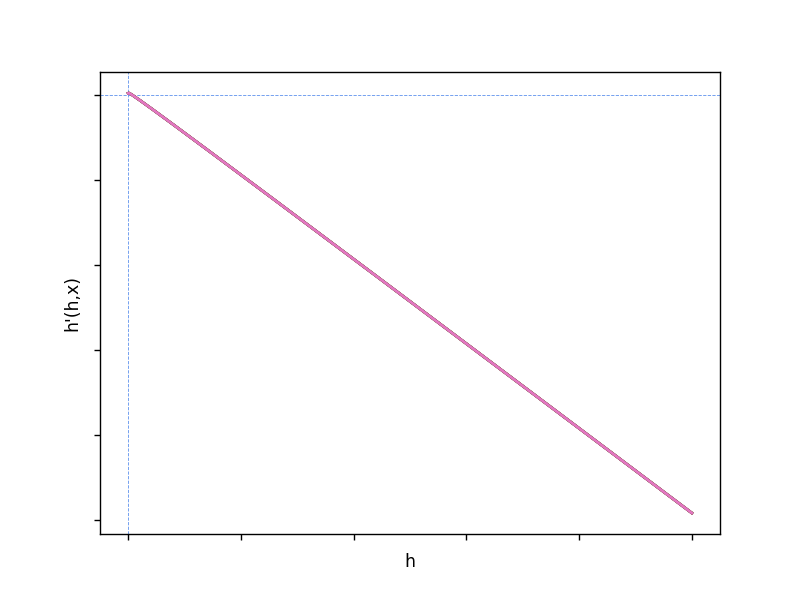

In [15]:
ncopy=copy.deepcopy(n)
hhcopy=copy.deepcopy(hh)
hd=(1-k)*ncopy-p*hhcopy

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.axhline(y=0,linewidth=0.5,color='cornflowerblue', linestyle='dashed')
plt.axvline(x=0,linewidth=0.5,color='cornflowerblue', linestyle='dashed')
for j in range(0,J,1):
    plt.plot(h,hd[:,j])
# plt.title("Sales for the first 6 months") #图名
plt.xlabel("h")#x轴标签
plt.ylabel("h'(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.savefig('figure6.9.1.pdf')#保存图片，一定要在show之前保存图片，否则保存的图片就为空白
plt.show()

### n的图像

<IPython.core.display.Javascript object>


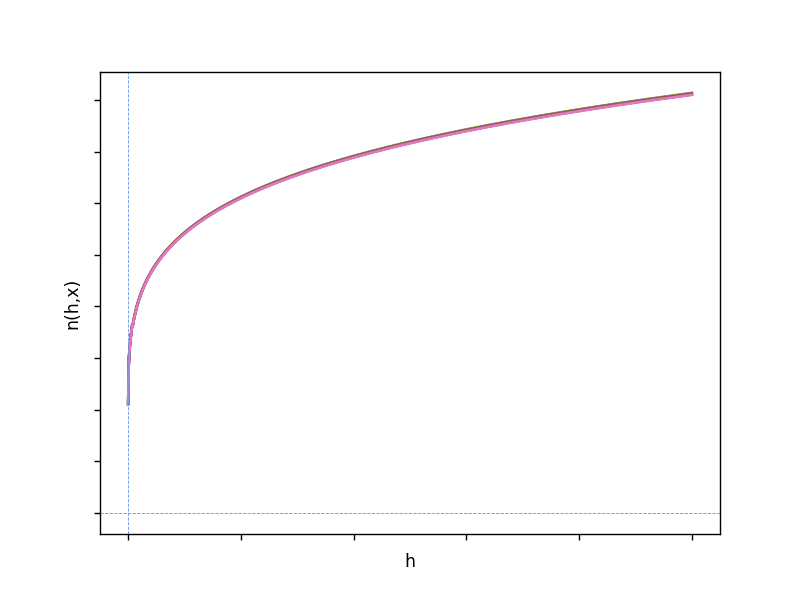

In [21]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,n[:,j])
plt.axhline(y=0,linewidth=0.5,color='cornflowerblue', linestyle='dashed')
plt.axvline(x=0,linewidth=0.5,color='cornflowerblue', linestyle='dashed')
plt.xlabel("h")#x轴标签
plt.ylabel("n(h,x)")#y轴标签
plt.tick_params(axis='both')#x,y轴都有刻度
# plt.savefig('figure3.10.2.pdf')

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.savefig('figure6.9.2.pdf')
plt.show()


<IPython.core.display.Javascript object>


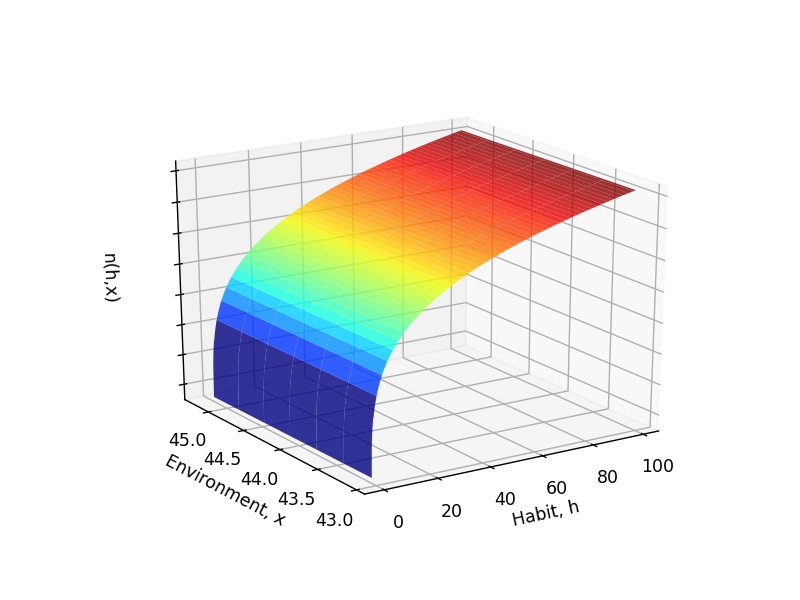

In [20]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

fig = plt.figure()

# ax.patch.set_facecolor("white") 



hcopy=copy.deepcopy(h)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=990;
hcut=hcopy[0:icut,:]
ncut=ncopy[0:icut,:]

hcut=hcut.reshape((1,icut))
ncut=np.transpose(ncut)

# max_ncut=a.any(max(ncut))
# min_ncut=min(ncut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,ncut,cmap='jet',alpha=0.8)
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('n(h,x)')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
plt.savefig('figure6.9.3.pdf')
plt.show()

### 价值函数的图像 

<IPython.core.display.Javascript object>


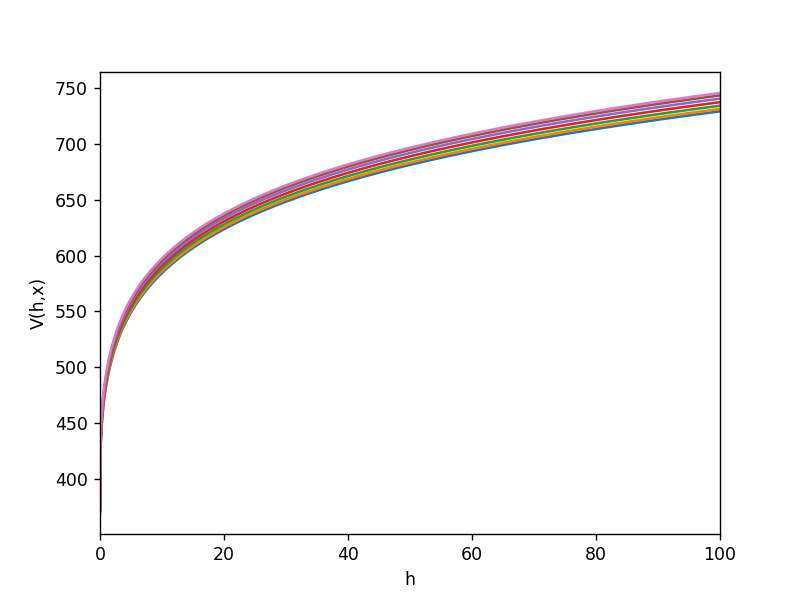

In [25]:
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

for j in range(0,J,1):
    plt.plot(h,V[:,j])
plt.xlabel("h")#x轴标签
plt.ylabel("V(h,x)")#y轴标签
plt.xlim(0,hmax)
# %plt.ylim(-1.75,0.5)
plt.tick_params(axis='both')#x,y轴都有刻度
# plt.savefig('figure2.png')
plt.savefig('figure6.9.4.pdf')
# plt.show()

### 分布的图像

<IPython.core.display.Javascript object>


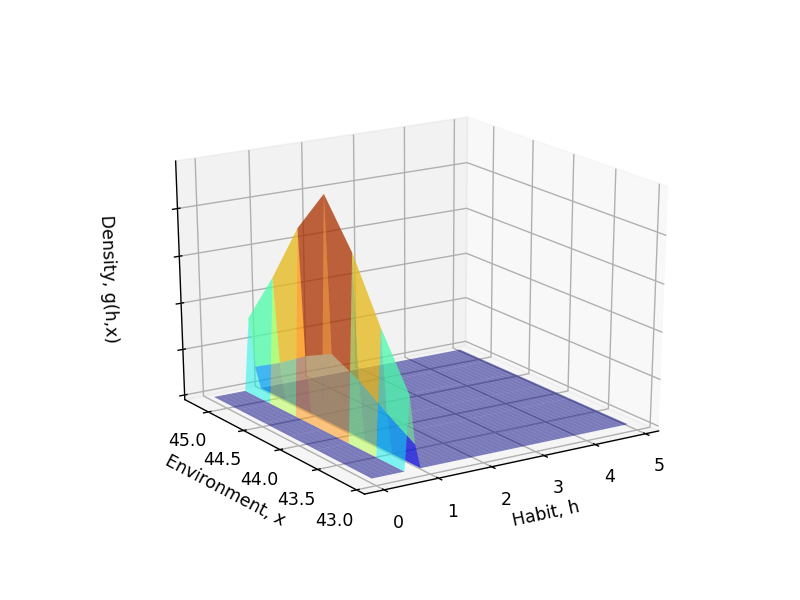

In [27]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

gcopy=copy.deepcopy(g)

# x=np.linspace(xmin,xmax,J);    # 行向量
# #print(x)
# x=x.reshape(1,J); 

icut=50;
hcut=hcopy[0:icut,:]
gcut=gcopy[0:icut,:]

hcut=hcut.reshape((1,icut))
gcut=np.transpose(gcut)

Xl,Yl = np.meshgrid(hcut[0],x[0])

fig = plt.figure()
ax = plt.gca(projection='3d')
ax.set_xlabel('Habit, h')
ax.set_ylabel('Environment, x')
ax.set_zlabel('Density, g(h,x)')
# ax.set_xlim(hmin,np.maximum(hcut))
# ax.set_ylim()
# ax.set_zlim()
# ax.add_collection3d(Poly3DCollection(poly3d, facecolors='w', linewidths=1, alpha=0.5))


# ax.add_collection3d(Poly3DCollection(ax,alpha=0.5))
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,gcut,cmap='jet',alpha=0.5)
ax.axes.zaxis.set_ticklabels([])
plt.savefig('figure6.9.5.pdf')
plt.show()